In [ ]:
# notebook copied from here:
# https://github.com/urchade/GLiNER/blob/main/examples/finetune.ipynb

import json
from gliner import GLiNER

import torch
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup
import os

# this function loads jsonl data
def read_jsonl(file_path):
    with open(file_path, "r") as f:
        data = [json.loads(line) for line in f]
    return data

### Load NER Dataset for Fine-Tuning

**TODO**: you need to load your own NER dataset here

In [8]:
train_path = 'data/argilla_dataset_train.jsonl'
eval_path = 'data/argilla_dataset_eval.jsonl'

train_data = read_jsonl(train_path)
eval_data = read_jsonl(eval_path)
len(train_data), len(eval_data)

(976, 24)

In [ ]:
# checking for gliner format
# {'tokenized_text' [], 'ner': [ [start_token_i, end_token_i, label], ...], ...}
print(f"{train_data[0]}\n\n{eval_data[3]}")

{'tokenized_text': ['When', 'you', 'would', 'like', 'the', 'property', 'photographed', '.', 'The', 'property', 'size', ',', 'home', 'size', ',', 'address', 'and', 'MLS', '#', 'if', 'you', 'have', 'it', '.'], 'ner': [[77, 84, 'address']]}

{'tokenized_text': ['Milosh', 'Roofing', 'Pittswood', 'is', 'your', 'ideal', 'partner', 'for', 'roof', 'maintenance', 'in', 'Pittswood', '.'], 'ner': [[0, 24, 'organization']]}


### Load Pre-Trained Model

In [34]:
# available models: https://huggingface.co/urchade

model = GLiNER.from_pretrained("urchade/gliner_largev2")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/egemenipek/miniconda3/envs/zero-shot-ner-lab/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Fine-Tuning Code

In [35]:
from types import SimpleNamespace

# Define the hyperparameters in a config variable
config = SimpleNamespace(
    # num_steps=10000, # number of training iteration
    num_steps=20, # low number of steps for testing NOTE: MODIFY THIS
    train_batch_size=2, 
    eval_every=2, # evaluation/saving steps
    save_directory="logs", # where to save checkpoints
    warmup_ratio=0.1, # warmup steps
    device='cpu',
    lr_encoder=1e-5, # learning rate for the backbone
    lr_others=5e-5, # learning rate for other parameters
    freeze_token_rep=False, # freeze of not the backbone
    
    # Parameters for set_sampling_params
    max_types=25, # maximum number of entity types during training
    shuffle_types=True, # if shuffle or not entity types
    random_drop=True, # randomly drop entity types
    max_neg_type_ratio=1, # ratio of positive/negative types, 1 mean 50%/50%, 2 mean 33%/66%, 3 mean 25%/75% ...
    max_len=384 # maximum sentence length
)

In [40]:
from gliner import Trainer

ImportError: cannot import name 'Trainer' from 'gliner' (/Users/egemenipek/miniconda3/envs/zero-shot-ner-lab/lib/python3.10/site-packages/gliner/__init__.py)

In [36]:
import numpy as np
import pandas as pd

In [ ]:
def train(model, config, train_data, eval_data=None):
    model = model.to(config.device)

    # Set sampling parameters from config
    model.set_sampling_params(
        max_types=config.max_types, 
        shuffle_types=config.shuffle_types, 
        random_drop=config.random_drop, 
        max_neg_type_ratio=config.max_neg_type_ratio, 
        max_len=config.max_len
    )
    
    model.train()

    # Initialize data loaders
    train_loader = model.create_dataloader(train_data, batch_size=config.train_batch_size, shuffle=True)

    # Optimizer
    optimizer = model.get_optimizer(config.lr_encoder, config.lr_others, config.freeze_token_rep)

    pbar = tqdm(range(config.num_steps))

    if config.warmup_ratio < 1:
        num_warmup_steps = int(config.num_steps * config.warmup_ratio)
    else:
        num_warmup_steps = int(config.warmup_ratio)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=config.num_steps
    )

    iter_train_loader = iter(train_loader)


    all_losses = []
    for step in pbar:
        try:
            x = next(iter_train_loader)
        except StopIteration:
            iter_train_loader = iter(train_loader)
            x = next(iter_train_loader)

        for k, v in x.items():
            if isinstance(v, torch.Tensor):
                x[k] = v.to(config.device)

        loss = model(x)  # Forward pass
            
        # Check if loss is nan
        if torch.isnan(loss):
            continue

        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
        scheduler.step()  # Update learning rate schedule
        optimizer.zero_grad()  # Reset gradients

        description = f"step: {step} | epoch: {step // len(train_loader)} | loss: {loss.item():.2f}"
        pbar.set_description(description)

        if (step + 1) % config.eval_every == 0:

            model.eval()
            
            if eval_data is not None:
                eval_losses =[]
               # results, f1 = model.evaluate(eval_data, flat_ner=True, threshold=0.5, batch_size=12,
               #                      entity_types=eval_data["entity_types"])


                eval_loader = model.create_dataloader(eval_data, batch_size=config.train_batch_size, shuffle=True)
                iter_eval_loader = iter(eval_loader)
                for step in pbar:
                    try:
                        x = next(iter_eval_loader)
                    except StopIteration:
                        iter_eval_loader = iter(eval_loader)
                        x = next(iter_eval_loader)
            
                    for k, v in x.items():
                        if isinstance(v, torch.Tensor):
                            x[k] = v.to(config.device)
            
                    loss = model(x)
                    eval_losses.append(loss.detach().numpy())
                print(f"average loss  on this run {np.mean(eval_losses)}")
                all_losses.append(np.mean(eval_losses))
                #print(f"Step={step}\n{results}")
                
            if not os.path.exists(config.save_directory):
                os.makedirs(config.save_directory)
                
            model.save_pretrained(f"{config.save_directory}/finetuned_{step}")

            model.train()

    return all_losses

### Run Fine-Tuning

In [38]:
# You can also define evaluation data manually here.
# For now, evaluation only support fix entity types (but can be easily extended)
# eval_data = {
#     "entity_types": ["Person", 'Event Reservation'],
#     "samples": data[:10]
# }
run_report = train(model, config, train_data, eval_data)

AttributeError: 'GLiNER' object has no attribute 'create_dataloader'

<Axes: >

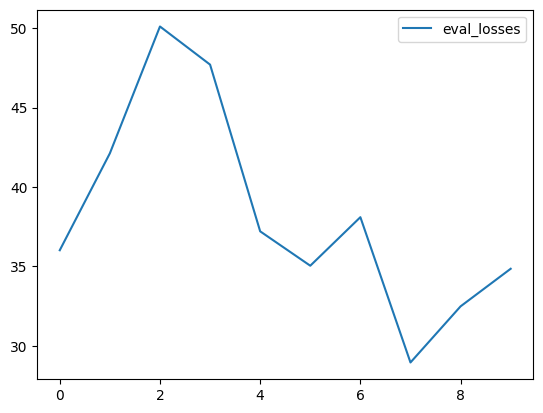

In [13]:
report_df = pd.DataFrame(run_report, columns = ["eval_losses"])
report_df.plot()

### Save and Load Fine-tuned Model

In [ ]:
model.save_pretrained("custom-model-small")

In [ ]:
loaded_model = GLiNER.from_pretrained("custom-model-small", local_files_only=True)

### Evaluate Model

In [ ]:
train_data[1]

In [ ]:
entity_types = sorted(set([t for item in eval_data for _, _, t in item['ner']]))
entity_types

In [ ]:
loaded_model.predict_entities("The Federal Reserve announced new guidelines for banking operations to enhance financial stability.", labels=['regulator'])

In [ ]:
eval_str, f1 = loaded_model.evaluate(test_data=eval_data, flat_ner=True, threshold=0.5, batch_size=1, entity_types=entity_types)
print(eval_str)

### Evaluation with Nervaluate

In [ ]:
eval_predictions = []
for item in eval_data:
    text = ' '.join(item["tokenized_text"])
    predictions = loaded_model.predict_entities(text, labels=entity_types)
    eval_predictions.append(predictions)

In [ ]:
def format_data_for_nervaluate(data):
    """
    Example for required format:
    true = [
    [{"label": "PER", "start": 2, "end": 4}],
    [{"label": "LOC", "start": 1, "end": 2},
     {"label": "LOC", "start": 3, "end": 4}]
    ]
    pred = [
        [{"label": "PER", "start": 2, "end": 4}],
        [{"label": "LOC", "start": 1, "end": 2},
        {"label": "LOC", "start": 3, "end": 4}]
    ]
    """
    formatted_data = []
    for item in data:
        formatted_entities = []
        for start, end, label in item['ner']:
            formatted_entities.append({"label": label, "start": start, "end": end})
        formatted_data.append(formatted_entities)
    return formatted_data

In [ ]:
formatted_eval_data = format_data_for_nervaluate(eval_data)

In [ ]:
from nervaluate import Evaluator
from pprint import pprint

# true = [
#     [{"label": "PER", "start": 2, "end": 4}],
#     [{"label": "LOC", "start": 1, "end": 2},
#      {"label": "LOC", "start": 3, "end": 4}]
# ]

# pred = [
#     [{"label": "PER", "start": 2, "end": 4}],
#     [{"label": "LOC", "start": 1, "end": 2},
#      {"label": "LOC", "start": 3, "end": 4}]
# ]

# evaluator = Evaluator(true, pred, tags=['LOC', 'PER'])

evaluator = Evaluator(formatted_eval_data, eval_predictions, tags=['tool'])

# Returns overall metrics and metrics for each tag

results, results_per_tag = evaluator.evaluate()

pprint(results)